In [48]:
import pandas as pd
import glob
import os

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# add reference alleles
reference = pd.read_csv('reference_genome.csv')

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# drop the n = 0 rows
# df_combined = df_combined[df_combined.n_total > 0]

# Display the combined DataFrame
df_combined.head()

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,OR.fixed,SE.fixed,p.fixed,beta.random,OR.random,SE.random,p.random,description,group,reference_hg38
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,0.999849,0.005953,0.979734,0.006178,1.006197,0.012305,0.615617,Dermatophytosis / Dermatomycosis,infectious diseases,C
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,0.999688,0.006069,0.959032,0.010304,1.010357,0.015522,0.506800,Dermatophytosis,infectious diseases,C
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,1.002185,0.006721,0.745428,0.009433,1.009478,0.016507,0.567693,Dermatophytosis of nail,infectious diseases,C
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,1.000275,0.010969,0.980001,0.018498,1.018670,0.022352,0.407917,Althete's foot,infectious diseases,C
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,1.027980,0.016599,0.096426,0.027595,1.027980,0.016599,0.096426,Dermatophytosis of the body,infectious diseases,C


In [49]:
# extract the SNP data
df_combined[['chrom', 'pos', 'alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# rename necessary cols
df_combined = df_combined.assign(

    # clean
    phenocode = df_combined.phenotype.astype(str),
    phenostring = df_combined.description,
    clean_phenotype = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace("[',\\]\\[\\(\\)/;&\\.]", "", regex = True),

    # rename
    reference = df_combined.reference_hg38,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,

    #maf = df_combined.assign(allele_freq2 = 1 - df_combined.allele_freq)[['allele_freq', 'allele_freq2']].min(axis = 1),
    maf = df_combined.allele_freq,

    # capitalize the first letter
    category = df_combined.group.str.slice(0,1).str.upper() + df_combined.group.str.slice(1),

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR

In [51]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'beta', 'se', 'or',  'num_samples', 'num_controls', 'num_cases', 'category', 'maf'
]

In [52]:
# drop all snps that where reference == alternate
df_combined = df_combined[df_combined.reference != df_combined.alternate] 

In [53]:
# check that we got all chromosomes
df_combined[df_combined.chrom.isna()][['snp'] + final_cols]

,snp,chrom,pos,reference,alternate,p,beta,se,or,num_samples,num_controls,num_cases,category,maf


In [54]:
df_combined

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,phenostring,clean_phenotype,reference,num_samples,num_controls,num_cases,se,maf,category,or
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,Dermatophytosis / Dermatomycosis,dermatophytosis__dermatomycosis,C,1237800,1060559,177241,0.005953,0.213625,Infectious diseases,0.999849
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,Dermatophytosis,dermatophytosis,C,1237416,1066906,170510,0.006069,0.213633,Infectious diseases,0.999688
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,Dermatophytosis of nail,dermatophytosis_of_nail,C,1251709,1123628,128081,0.006721,0.213452,Infectious diseases,1.002185
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,Althete's foot,althetes_foot,C,1251344,1214540,36804,0.010969,0.213629,Infectious diseases,1.000275
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,Dermatophytosis of the body,dermatophytosis_of_the_body,C,1258137,1244926,13211,0.016599,0.213669,Infectious diseases,1.027980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62428,994.00,7:41266132_A,none,0.012255,1.012331,0.007933,0.122374,logistic,1341097,36813,...,Sepsis and SIRS,sepsis_and_sirs,G,1341097,1304284,36813,0.007933,0.516118,Injuries & poisonings,1.012331
62429,994.10,7:41266132_A,none,0.007507,1.007535,0.027067,0.781516,logistic,1285442,2926,...,Systemic inflammatory response syndrome (SIRS),systemic_inflammatory_response_syndrome_sirs,G,1285442,1282516,2926,0.027067,0.520728,Injuries & poisonings,1.007535
62430,994.20,7:41266132_A,none,0.012152,1.012226,0.008283,0.142336,logistic,1340915,33612,...,Sepsis,sepsis,G,1340915,1307303,33612,0.008283,0.516177,Injuries & poisonings,1.012226
62431,994.21,7:41266132_A,none,NaN,NaN,NaN,NaN,NaN,0,0,...,Septic shock,septic_shock,G,0,0,0,NaN,NaN,Injuries & poisonings,NaN


In [55]:
# sort
df_combined = df_combined.sort_values('phenocode')

In [56]:
# final file
df_combined[['phenocode', 'phenostring', 'clean_phenotype'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

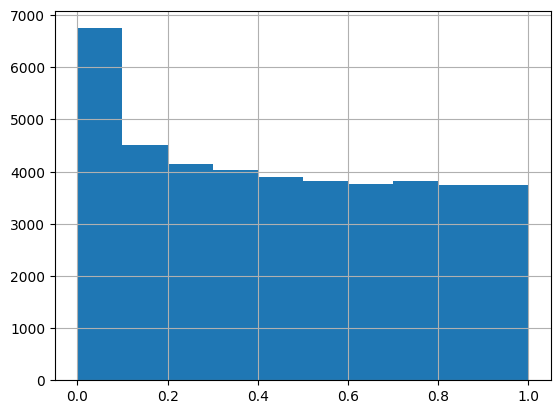

In [57]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

I need to format the files a la Github specifications. One file per phenotype

In [58]:
# filtering out phenotypes with n = 0
# this isn't a problem with the phenotypes, this is because we filtered out some genes because the reference alleles didn't match
n_totals = df_combined.groupby('phenocode').n_total.sum()
phenotypes_n_0 = pd.Series(n_totals[n_totals == 0].index)
df_combined = df_combined[~ df_combined.phenocode.isin(phenotypes_n_0)]

In [59]:
unique_phenotypes = df_combined[['phenocode', 'phenostring', 'category', 'clean_phenotype']].drop_duplicates()

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != df_combined.phenocode.nunique():
    raise ValueError("Non-unique phenotype categories. One or more phenotypes have multiple categories")

In [60]:
df_combined.columns

Index(['phenotype', 'snp', 'adjustment', 'beta', 'OR', 'SE', 'p', 'type',
       'n_total', 'n_cases', 'n_controls', 'HWE_p.min', 'allele_freq',
       'n_no_snp', 'k_studies', 'tau2', 'I2.percent', 'Q', 'Q.df', 'Q.p',
       'beta.fixed', 'OR.fixed', 'SE.fixed', 'p.fixed', 'beta.random',
       'OR.random', 'SE.random', 'p.random', 'description', 'group',
       'reference_hg38', 'chrom', 'pos', 'alternate', 'phenocode',
       'phenostring', 'clean_phenotype', 'reference', 'num_samples',
       'num_controls', 'num_cases', 'se', 'maf', 'category', 'or'],
      dtype='object')

In [61]:
# df_combined[['phenocode', 'phenostring', 'category', 'n_total', 'snp']].drop_duplicates().head(20)

In [62]:
# remove all files in folder
import os
import glob

files = glob.glob('clean_data/*')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in unique_phenotypes.clean_phenotype:
    df_combined[df_combined.phenocode == pheno][final_cols].to_csv('clean_data/' + str(pheno) + '.csv', index = False)

In [63]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv')[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [64]:
pheno_df

,assoc_files,category,phenocode,phenostring
0,clean_data/dermatophytosis__dermatomycosis.csv,Infectious diseases,110.0,Dermatophytosis / Dermatomycosis
6061,clean_data/dermatophytosis.csv,Infectious diseases,110.1,Dermatophytosis
2024,clean_data/dermatophytosis_of_nail.csv,Infectious diseases,110.11,Dermatophytosis of nail
12121,clean_data/althetes_foot.csv,Infectious diseases,110.12,Althete's foot
42236,clean_data/dermatophytosis_of_the_body.csv,Infectious diseases,110.13,Dermatophytosis of the body
...,...,...,...,...
8073,clean_data/effects_radiation_nos.csv,Injuries & poisonings,990.0,Effects radiation NOS
52333,clean_data/sepsis_and_sirs.csv,Injuries & poisonings,994.0,Sepsis and SIRS
28088,clean_data/systemic_inflammatory_response_synd...,Injuries & poisonings,994.1,Systemic inflammatory response syndrome (SIRS)
62430,clean_data/sepsis.csv,Injuries & poisonings,994.2,Sepsis


In [65]:
pheno_df.phenocode.value_counts()

phenocode
994.21    1
110.0     1
110.1     1
110.11    1
110.12    1
         ..
134.0     1
133.0     1
132.1     1
132.0     1
131.0     1
Name: count, Length: 1759, dtype: int64

In [66]:
for i in pheno_df.phenocode:
    print(i)

110.0
110.1
110.11
110.12
110.13
110.2
112.0
112.3
117.0
117.1
117.2
117.3
117.4
130.0
130.1
131.0
132.0
132.1
133.0
134.0
134.1
136.0
145.0
145.1
145.2
145.3
145.4
145.5
149.0
149.1
149.2
149.3
149.4
149.5
149.9
150.0
151.0
153.0
153.2
153.3
155.0
155.1
157.0
158.0
159.0
159.2
159.3
159.4
164.0
165.0
165.1
170.0
170.1
170.2
172.0
172.1
172.11
172.2
172.21
172.22
172.3
173.0
174.0
174.1
174.11
174.2
174.3
175.0
180.0
180.1
180.3
182.0
184.0
184.1
184.11
184.2
185.0
187.0
187.1
187.2
187.8
189.0
189.1
189.11
189.12
189.2
189.21
189.4
190.0
191.0
191.1
191.11
193.0
194.0
195.0
195.1
195.3
196.0
197.0
198.0
198.1
198.2
198.3
198.4
198.5
198.6
198.7
199.0
199.4
200.0
200.1
201.0
202.0
202.2
202.21
202.22
202.23
202.24
204.0
204.1
204.11
204.12
204.2
204.21
204.22
204.3
204.4
208.0
209.0
210.0
211.0
212.0
213.0
214.0
214.1
215.0
216.0
216.1
217.0
217.1
218.0
218.1
218.2
220.0
221.0
222.0
223.0
224.0
224.1
225.0
225.1
225.2
226.0
227.0
227.1
227.2
227.3
228.0
228.1
229.0
229.1
230.0
240.0
24